In [1]:
import numpy as np
from astropy.table import Table
import pylab as pl

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics  import r2_score
import pickle
import os

from tqdm import tqdm

pl.style.use('/pscratch/sd/j/jfsuarez/plots.mplstyle')

In [2]:
def np_unstrcuted(A):
    A = np.array(A, copy=True)
    return A.view((float, len(A.dtype.names)))

def metrics(Y_test, Y_pred):
    Delta_Z = Y_pred - Y_test
    bias = Delta_Z/(1+Y_test)
    sigma_nmad = np.median(np.abs(bias - np.median(bias)))
    f_out = np.sum(np.abs(bias) > 0.05)/len(Y_pred)*100
    return bias, sigma_nmad, f_out

def mw_transmission(ebv, band):
    coeffs = {'U':3.995, 'G': 3.214, 'R': 2.165, 'I': 1.592, 'Z': 1.211, 'Y': 1.064,
              'W1': 0.184, 'W2': 0.113, 'W3': 0.0241, 'W4': 0.00910}
    return 10**(coeffs[band]*ebv/-2.5)

def mag(flux, ebv, band):
    return 22.5 - 2.5*np.log10(flux/mw_transmission(ebv, band))

In [3]:
data_file = '../../data/deepgn/catalog_guadalupe_main_bgs/photo_features_full.csv'
data = Table.read(data_file)
data

<Table length=825362>
     TARGETID              Z           ...         EBV         
      int64             float64        ...       float64       
----------------- -------------------- ... --------------------
39627541597651211  0.10465148000721934 ...  0.03457134589552879
39627541597651384  0.20723219232576198 ...  0.03669583052396774
39627541601845289  0.34257429377805054 ...  0.04405784606933594
39627541606039631  0.41999844048285995 ... 0.036424990743398666
39627541606039677   0.3323346693623744 ... 0.036557916551828384
39627541606039880  0.22767768425646814 ...  0.03745713084936142
39627547490648172  0.21990599447706743 ... 0.041514817625284195
39627547490648176  0.24034261154657718 ...  0.04253032058477402
39627547490648342   0.0688902953313014 ...  0.04193524643778801
39627547490648764  0.18921928265323812 ... 0.040298767387866974
              ...                  ... ...                  ...
39637330885084473    0.140182594670623 ...  0.08453332632780075
39637330885084662   0.4681153425473922 ...  0.08383795619010925
39637330885085294   0.3456888895147781 ...  0.08230051398277283
39637330885085953   0.4612942421895889 ...  0.08196190744638443
39637330885086337  0.11930735257850753 ...  0.08492057025432587
39637330885087431  0.42164491508132684 ...  0.09065950661897659
39637330885087784  0.16075618269700442 ...  0.08482547104358673
39637330885087875  0.31641716071315273 ...  0.09035468101501465
39637341018526528 0.034248581708430356 ...  0.11530822515487671
39637341018526951   0.3168911376012401 ...  0.13105683028697968

In [4]:
# What means negative flux??
data = data[data['FLUX_W1']>0]
data = data[data['FLUX_W2']>0]

In [5]:
MAG_G    =  mag(data['FLUX_G'], data['EBV'], 'G')
MAG_R    =  mag(data['FLUX_R'], data['EBV'], 'R')
MAG_Z    =  mag(data['FLUX_Z'], data['EBV'], 'Z')
MAG_W1   =  mag(data['FLUX_W1'], data['EBV'], 'W1')
MAG_W2   =  mag(data['FLUX_W2'], data['EBV'], 'W2')

MAGG_R    =  MAG_G - MAG_R
MAGR_Z    =  MAG_R - MAG_Z
MAGZ_W1   =  MAG_Z - MAG_W1
MAGW1_W2  =  MAG_W1 - MAG_W2
HL_RADIUS = data['SHAPE_R']
RATIO_BA  = data['RATIO_BA']
Z         = data['Z']
LABEL     = data['LABEL']

In [6]:
X = Table([MAG_G, MAG_R, MAGG_R, MAGR_Z, MAGZ_W1, MAGW1_W2, HL_RADIUS, RATIO_BA], names=('MAG_G','MAG_R','MAG_G-R','MAG_R-Z','MAG_Z-W1','MAG_W2-W1','HL_RADIUS','RATIO_BA'))
Y = Table([Z], names=('Z'))

In [7]:
X_train = np_unstrcuted(X[LABEL=='train'])
X_test  = np_unstrcuted(X[LABEL=='test'])
X_valid = np_unstrcuted(X[LABEL=='valid'])

In [8]:
Y_train = np_unstrcuted(Y[LABEL=='train'])
Y_test  = np_unstrcuted(Y[LABEL=='test'])
Y_valid = np_unstrcuted(Y[LABEL=='valid'])

/tmp/ipykernel_132803/1092611674.py:3: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  return A.view((float, len(A.dtype.names)))


In [9]:
len(Y_train), len(Y_test), len(Y_valid)

(574024, 164039, 82392)

### RandomForestRegressor

In [10]:
NE = np.linspace(20,400,5, dtype=int)
MD = np.linspace(10,30,5, dtype=int)

r_train = []
r_test  = []

pbar = tqdm(total=len(NE)*len(MD))
for i, ne in enumerate(NE):
    for j, md in enumerate(MD):
        filename_model = f'./model/classic/rf_ne{ne}_md{md}.pkl'
        
        if os.path.isfile(filename_model):
            model = pickle.load(open(filename_model, "rb"))
        else:
            model = RandomForestRegressor(n_estimators=ne, max_depth=md, max_features='sqrt')
            model.fit(X_train, Y_train)
            pickle.dump(model, open(filename_model, "wb"))
        Y_ptrain = model.predict(X_train)
        Y_ptest  = model.predict(X_test)

        _, sig_nmad_ts, f_out_ts = metrics(Y_test, Y_ptest)
        r_test.append((ne,md,r2_score(Y_test, Y_ptest), sig_nmad_ts, f_out_ts))

        _, sig_nmad_tr, f_out_tr = metrics(Y_train, Y_ptrain)
        r_train.append((ne,md,r2_score(Y_train, Y_ptrain), sig_nmad_tr, f_out_tr))
        
        pbar.update()
pbar.close()

r_train = Table( np.array(r_train), names=('NE','MD','r2','sig_nmad','f_out'))
r_test =  Table( np.array(r_test), names=('NE','MD','r2','sig_nmad','f_out'))

100%|██████████| 25/25 [17:05<00:00, 41.00s/it]


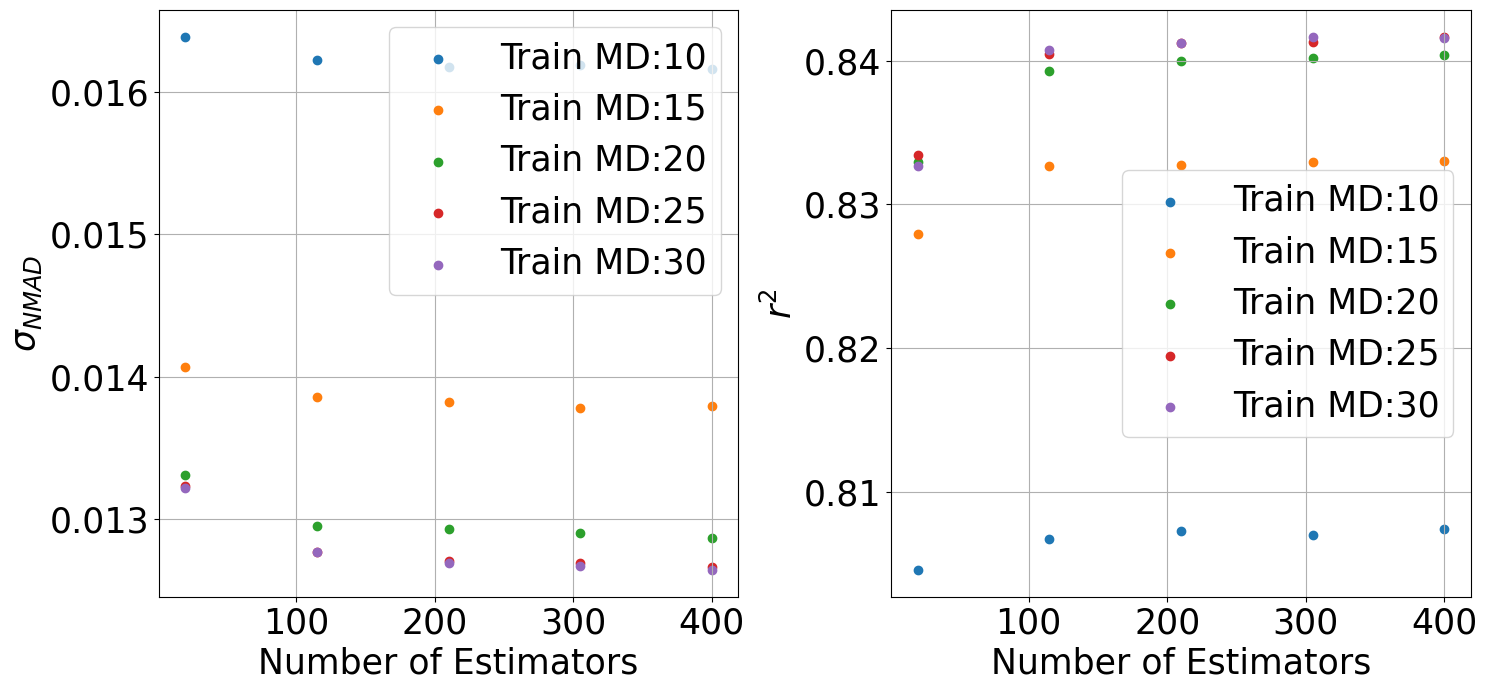

  NE   MD          r2               sig_nmad             f_out      
----- ---- ------------------ -------------------- -----------------
400.0 30.0 0.8415721871341044 0.012641205612459254 6.550881192887058


In [11]:
fig = pl.figure(figsize=(15,7))
pl.subplot(1,2,1)
for i, md in enumerate(MD):
    ii = r_test['MD'] == md
    pl.scatter(r_test['NE'][ii], r_test['sig_nmad'][ii], label=f'Train MD:{md}')
    # pl.scatter(NE[i], r_train, label=f'Train MD:{md}')
    # ii_best = np.argmax(r2_test)
    # pl.plot(NE[ii_best], r2_test[ii_best], 'x')
    pl.xlabel('Number of Estimators')
    pl.ylabel(r'$\sigma_{NMAD}$')
pl.legend()
pl.grid()
pl.subplot(1,2,2)
for i, md in enumerate(MD):
    ii = r_test['MD'] == md
    pl.scatter(r_test['NE'][ii], r_test['r2'][ii], label=f'Train MD:{md}')
    # pl.scatter(NE[i], r_train, label=f'Train MD:{md}')
    # ii_best = np.argmax(r2_test)
    # pl.plot(NE[ii_best], r2_test[ii_best], 'x')
    pl.xlabel('Number of Estimators')
    pl.ylabel(r'$r^2$')
pl.tight_layout()
pl.legend()
pl.grid()
pl.show()

ii_best = np.argmin(r_test['sig_nmad'])
print(r_test[ii_best])

In [12]:
model = RandomForestRegressor(n_estimators=int(r_test['NE'][ii_best]), max_depth=int(r_test['MD'][ii_best]), max_features='sqrt')
model.fit(X_train, Y_train)

RandomForestRegressor(max_depth=30, max_features='sqrt', n_estimators=400)

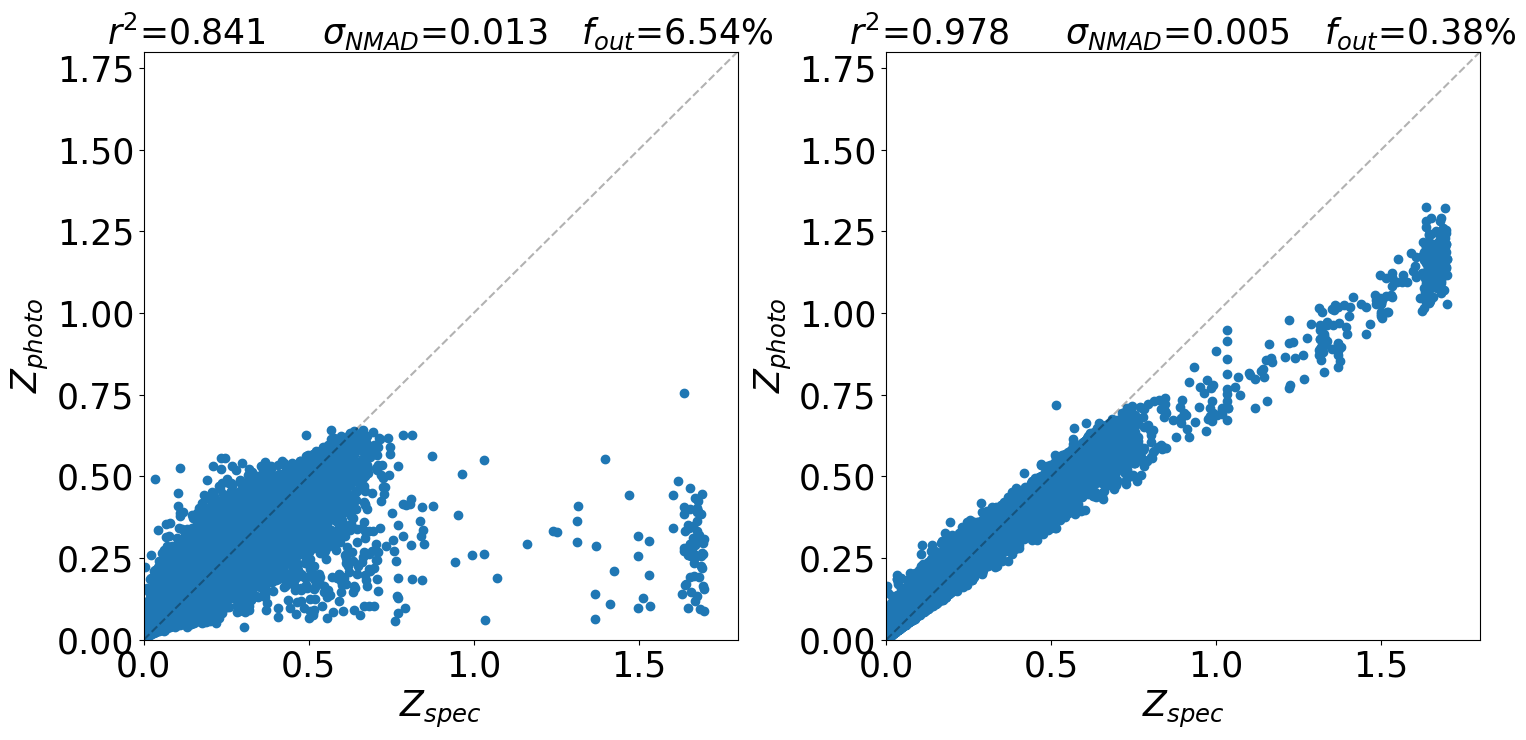

In [13]:
fig = pl.figure(figsize=(15,7.5))
pl.subplot(1,2,1)
Y_pred = model.predict(X_test)
pl.scatter(Y_test, Y_pred)
pl.xlabel(r'$Z_{spec}$')
pl.ylabel(r'$Z_{photo}$')
_, sig_nmad_ts, f_out_ts = metrics(Y_test, Y_pred)
pl.title(r'$r^2$='+f'{r2_score(Y_test,Y_pred):.3f}\t'+r'$\sigma_{NMAD}$='+f'{sig_nmad_ts:.3f}\t'+r'$f_{out}$='+f'{f_out_ts:.2f}%')
pl.plot(np.linspace(0,2,5), np.linspace(0,2,5), '--k', alpha=0.3)
pl.xlim(0,1.8)
pl.ylim(0,1.8)

pl.subplot(1,2,2)
Y_pred = model.predict(X_train)
pl.scatter(Y_train, Y_pred)
pl.xlabel(r'$Z_{spec}$')
pl.ylabel(r'$Z_{photo}$')
_, sig_nmad_tr, f_out_tr = metrics(Y_train, Y_pred)
pl.title(r'$r^2$='+f'{r2_score(Y_train,Y_pred):.3f}\t'+r'$\sigma_{NMAD}$='+f'{sig_nmad_tr:.3f}\t'+r'$f_{out}$='+f'{f_out_tr:.2f}%')
pl.plot(np.linspace(0,2,5), np.linspace(0,2,5), '--k', alpha=0.3)
pl.xlim(0,1.8)
pl.ylim(0,1.8)
pl.tight_layout()
pl.show()

r_test.to_pandas().to_csv('RF_test.csv')
r_train.to_pandas().to_csv('RF_train.csv')

### Gradient Boosting Regressor

In [14]:
# NE = np.linspace(20,300,5, dtype=int)
# MD = np.linspace(10,30,5, dtype=int)

r_train = []
r_test = []


pbar = tqdm(total=len(NE)*len(MD))
for i, ne in enumerate(NE):
    for j, md in enumerate(MD):
        filename_model = f'./model/classic/gb_ne{ne}_md{md}.pkl'
        
        if os.path.isfile(filename_model):
            model = pickle.load(open(filename_model, "rb"))
        else:
            model = GradientBoostingRegressor(n_estimators=ne, max_depth=md)
            model.fit(X_train, Y_train)
            pickle.dump(model, open(filename_model, "wb"))

        Y_ptrain = model.predict(X_train)
        Y_ptest  = model.predict(X_test)

        _, sig_nmad_ts, f_out_ts = metrics(Y_test, Y_ptest)
        r_test.append((ne,md,r2_score(Y_test, Y_ptest), sig_nmad_ts, f_out_ts))

        _, sig_nmad_tr, f_out_tr = metrics(Y_train, Y_ptrain)
        r_train.append((ne,md,r2_score(Y_train, Y_ptrain), sig_nmad_tr, f_out_tr))
        
        pbar.update()
pbar.close()

r_train = Table( np.array(r_train), names=('NE','MD','r2','sig_nmad','f_out'))
r_test =  Table( np.array(r_test), names=('NE','MD','r2','sig_nmad','f_out'))

100%|██████████| 25/25 [12:54:21<00:00, 1858.46s/it]  


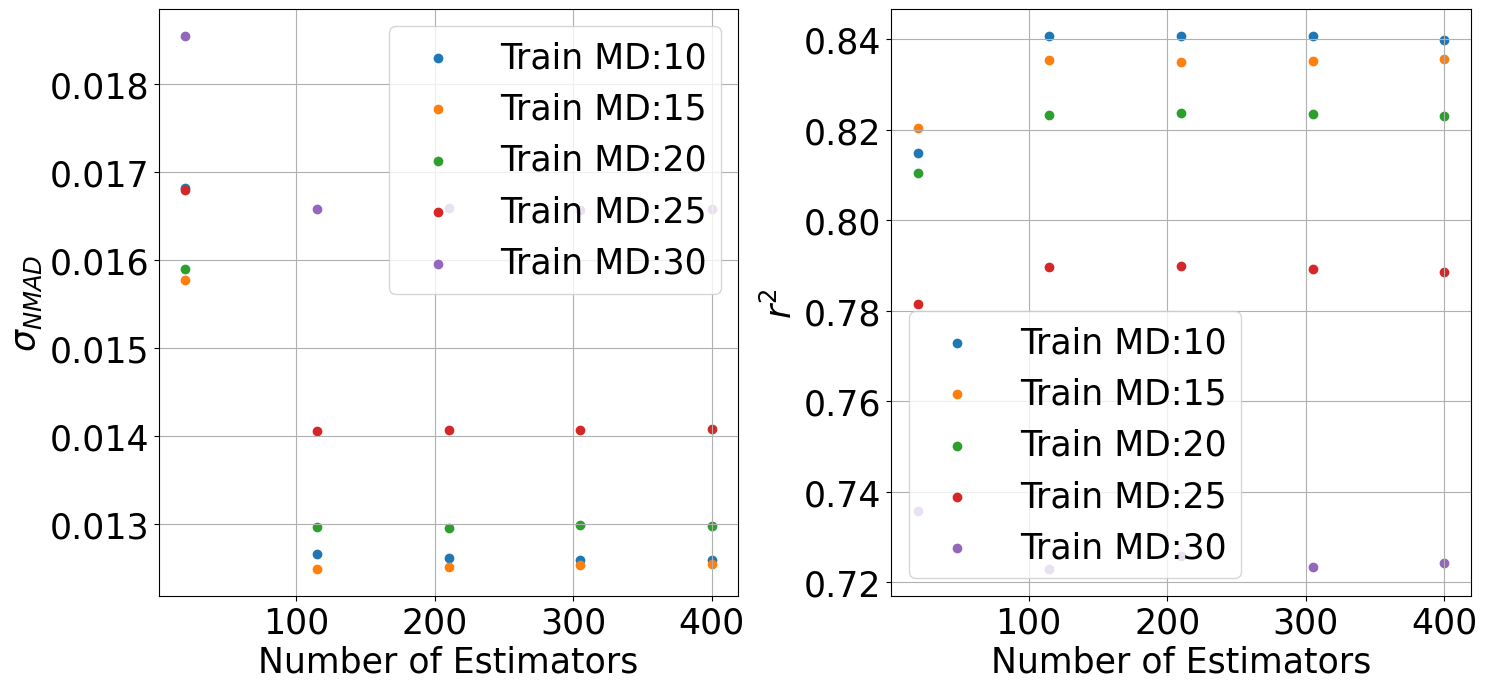

  NE   MD          r2               sig_nmad            f_out      
----- ---- ------------------ ------------------- -----------------
115.0 15.0 0.8353716089230203 0.01249105269124811 6.716695419991588


In [15]:
fig = pl.figure(figsize=(15,7))
pl.subplot(1,2,1)
for i, md in enumerate(MD):
    ii = r_test['MD'] == md
    pl.scatter(r_test['NE'][ii], r_test['sig_nmad'][ii], label=f'Train MD:{md}')
    # pl.scatter(NE[i], r_train, label=f'Train MD:{md}')
    # ii_best = np.argmax(r2_test)
    # pl.plot(NE[ii_best], r2_test[ii_best], 'x')
    pl.xlabel('Number of Estimators')
    pl.ylabel(r'$\sigma_{NMAD}$')
pl.legend()
pl.grid()
pl.subplot(1,2,2)
for i, md in enumerate(MD):
    ii = r_test['MD'] == md
    pl.scatter(r_test['NE'][ii], r_test['r2'][ii], label=f'Train MD:{md}')
    # pl.scatter(NE[i], r_train, label=f'Train MD:{md}')
    # ii_best = np.argmax(r2_test)
    # pl.plot(NE[ii_best], r2_test[ii_best], 'x')
    pl.xlabel('Number of Estimators')
    pl.ylabel(r'$r^2$')
pl.tight_layout()
pl.legend()
pl.grid()
pl.show()

ii_best = np.argmin(r_test['sig_nmad'])
print(r_test[ii_best])

In [16]:
model = GradientBoostingRegressor(n_estimators=int(r_test['NE'][ii_best]), max_depth=int(r_test['MD'][ii_best]), max_features='sqrt')
model.fit(X_train, Y_train)

GradientBoostingRegressor(max_depth=15, max_features='sqrt', n_estimators=115)

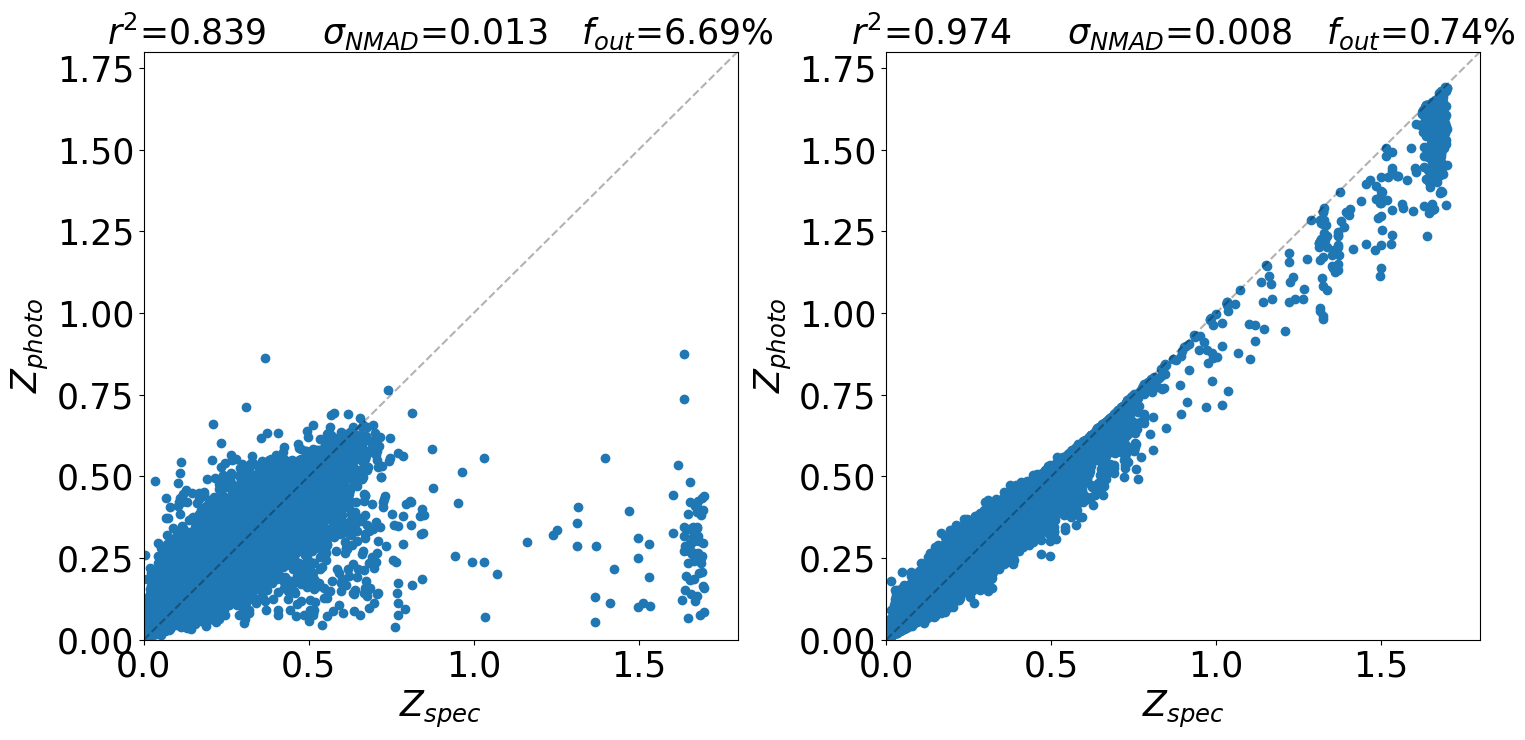

In [17]:
fig = pl.figure(figsize=(15,7.5))
pl.subplot(1,2,1)
Y_pred = model.predict(X_test)
pl.scatter(Y_test, Y_pred)
pl.xlabel(r'$Z_{spec}$')
pl.ylabel(r'$Z_{photo}$')
_, sig_nmad_ts, f_out_ts = metrics(Y_test, Y_pred)
pl.title(r'$r^2$='+f'{r2_score(Y_test,Y_pred):.3f}\t'+r'$\sigma_{NMAD}$='+f'{sig_nmad_ts:.3f}\t'+r'$f_{out}$='+f'{f_out_ts:.2f}%')
pl.plot(np.linspace(0,2,5), np.linspace(0,2,5), '--k', alpha=0.3)
pl.xlim(0,1.8)
pl.ylim(0,1.8)

pl.subplot(1,2,2)
Y_pred = model.predict(X_train)
pl.scatter(Y_train, Y_pred)
pl.xlabel(r'$Z_{spec}$')
pl.ylabel(r'$Z_{photo}$')
_, sig_nmad_tr, f_out_tr = metrics(Y_train, Y_pred)
pl.title(r'$r^2$='+f'{r2_score(Y_train,Y_pred):.3f}\t'+r'$\sigma_{NMAD}$='+f'{sig_nmad_tr:.3f}\t'+r'$f_{out}$='+f'{f_out_tr:.2f}%')
pl.plot(np.linspace(0,2,5), np.linspace(0,2,5), '--k', alpha=0.3)
pl.xlim(0,1.8)
pl.ylim(0,1.8)
pl.tight_layout()
pl.show()

r_test.to_pandas().to_csv('GB_test.csv')
r_train.to_pandas().to_csv('GB_train.csv')